Again!!!! This is a trash file.

After trying on creating my own RBM, I decided to also go through the available packages for RBM.

In [9]:
using Pkg
Pkg.add("Makie")

   Resolving package versions...
   Installed EarCut_jll ──────────── v2.2.4+0
   Installed TriplotBase ─────────── v0.1.0
   Installed SignedDistanceFields ── v0.4.0
   Installed FilePaths ───────────── v0.8.3
   Installed PolygonOps ──────────── v0.1.2
   Installed RoundingEmulator ────── v0.2.1
   Installed AdaptivePredicates ──── v1.2.0
   Installed isoband_jll ─────────── v0.2.3+0
   Installed Isoband ─────────────── v0.1.1
   Installed GridLayoutBase ──────── v0.11.0
   Installed FreeType ────────────── v4.1.1
   Installed FreeTypeAbstraction ─── v0.10.3
   Installed Automa ──────────────── v1.0.4
   Installed Packing ─────────────── v0.5.0
   Installed ExactPredicates ─────── v2.2.8
   Installed Extents ─────────────── v0.1.4
   Installed KernelDensity ───────── v0.6.9
   Installed GeoFormatTypes ──────── v0.4.2
   Installed IntervalArithmetic ──── v0.22.17
   Installed MathTeXEngine ───────── v0.6.1
   Installed MakieCore ───────────── v0.8.9
   Installed ColorBrewer ──────────

In [10]:
Pkg.add("CairoMakie")
Pkg.add("MLDatasets")
Pkg.add("Statistics")
Pkg.add("RestrictedBoltzmannMachines")

   Resolving package versions...
   Installed CairoMakie ─ v0.12.14
   Installed Cairo ────── v1.1.0
    Updating `C:\Users\vishv\.julia\environments\v1.10\Project.toml`
  [13f3f980] + CairoMakie v0.12.14
    Updating `C:\Users\vishv\.julia\environments\v1.10\Manifest.toml`
  [159f3aea] + Cairo v1.1.0
  [13f3f980] + CairoMakie v0.12.14
Precompiling project...
  ✓ Cairo
CairoMakie Waiting for background task / IO / timer.
[pid 16744] waiting for IO to finish:
 Handle type        uv_handle_t->data
 timer              000002577ee2af70->000002577d967f40
This means that a package has started a background task or event source that has not finished running. For precompilation to complete successfully, the event source needs to be closed explicitly. See the developer documentation on fixing precompilation hangs for more help.
  ✓ CairoMakie
  2 dependencies successfully precompiled in 99 seconds. 464 already precompiled. 69 skipped during auto due to previous errors.
  1 dependency had output 

In [2]:
import Pkg
import CairoMakie
import MLDatasets
using Statistics: mean, std, var
using Random: bitrand
using ValueHistories: MVHistory, @trace
using RestrictedBoltzmannMachines: BinaryRBM, sample_from_inputs,
    initialize!, log_pseudolikelihood, pcd!, free_energy, sample_v_from_v

In [3]:
"""
    imggrid(A)

Given a four dimensional tensor `A` of size `(width, height, ncols, nrows)`
containing `width x height` images in a grid of `nrows x ncols`, this returns
a matrix of size `(width * ncols, height * nrows)`, that can be plotted in a heatmap
to display all images.
"""
imggrid(A::AbstractArray{<:Any,4}) =
    reshape(permutedims(A, (1,3,2,4)), size(A,1)*size(A,3), size(A,2)*size(A,4))

imggrid

In [4]:
Main.imggrid

imggrid (generic function with 1 method)

In [5]:
Float = Float32
train_x = MLDatasets.MNIST(split=:train)[:].features
train_y = MLDatasets.MNIST(split=:train)[:].targets
train_x = Array{Float}(train_x[:, :, train_y .== 0] .≥ 0.5)

28×28×5923 Array{Float32, 3}:
[:, :, 1] =
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     1.0  1.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     1.0  1.0  1.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     1.0  1.0  1.0  0.0  0.0  0.0  0.0
 ⋮                        ⋮              ⋱                      ⋮         
 0.0  0.0  0.0  0.0  0.0  1.0  1.0  1.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0 

┌ Warning: Found `resolution` in the theme when creating a `Scene`. The `resolution` keyword for `Scene`s and `Figure`s has been deprecated. Use `Figure(; size = ...` or `Scene(; size = ...)` instead, which better reflects that this is a unitless size and not a pixel resolution. The key could also come from `set_theme!` calls or related theming functions.
└ @ Makie C:\Users\vishv\.julia\packages\Makie\6c4lt\src\scenes.jl:229


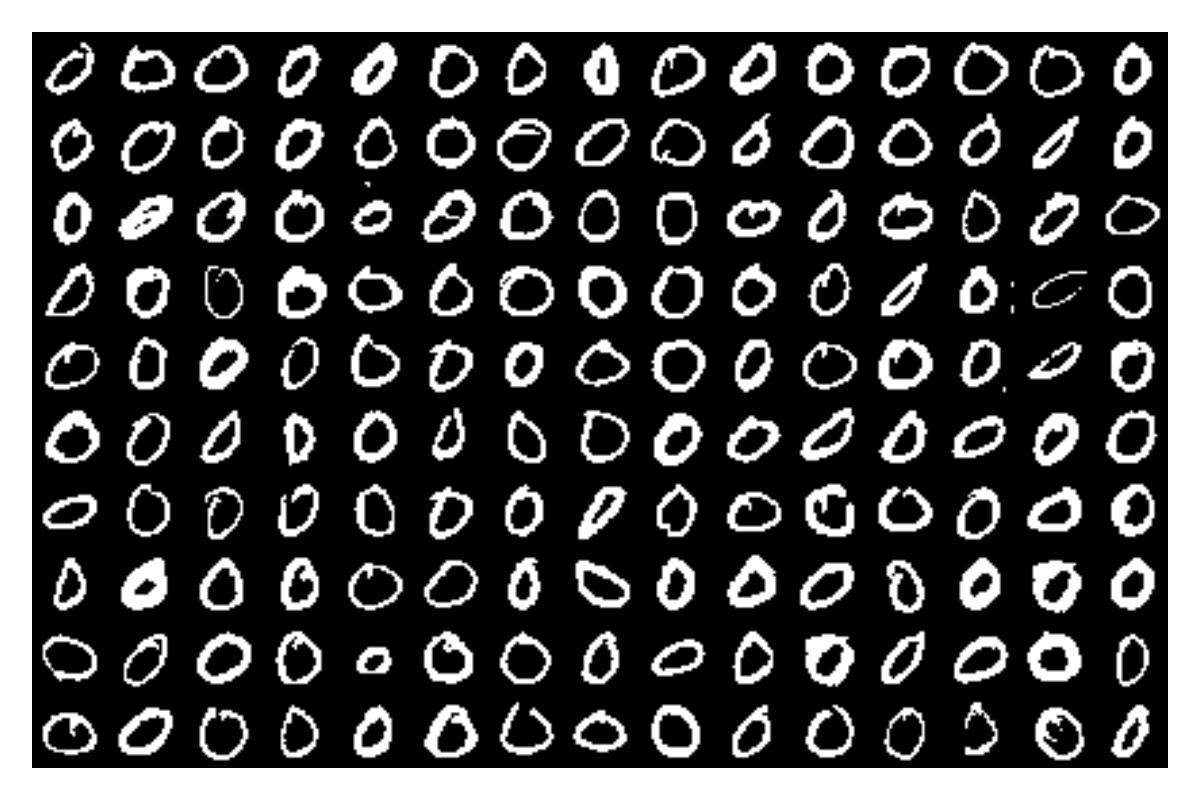

In [18]:
nrows, ncols = 10, 15
fig = Makie.Figure(resolution=(40ncols, 40nrows))
ax = Makie.Axis(fig[1,1], yreversed=true)
idx = rand(1:size(train_x,3), nrows * ncols) # random indices of digits
digits = reshape(train_x[:,:,idx], 28, 28, ncols, nrows)
Makie.image!(ax, imggrid(digits), colorrange=(1,0))
Makie.hidedecorations!(ax)
Makie.hidespines!(ax)
fig

In [7]:
rbm = BinaryRBM(Float, (28,28), 400)
initialize!(rbm, train_x) # match single-site statistics

RestrictedBoltzmannMachines.RBM{RestrictedBoltzmannMachines.Binary{2, Array{Float32, 3}}, RestrictedBoltzmannMachines.Binary{1, Matrix{Float32}}, Array{Float32, 3}}(RestrictedBoltzmannMachines.Binary{2, Array{Float32, 3}}(Float32[-13.81551 -13.81551 … -13.81551 -13.81551;;; -13.81551 -13.81551 … -13.81551 -13.81551;;; -13.81551 -13.81551 … -13.81551 -13.81551;;; … ;;; -13.81551 -13.81551 … -13.81551 -13.81551;;; -13.81551 -13.81551 … -13.81551 -13.81551;;; -13.81551 -13.81551 … -13.81551 -13.81551]), RestrictedBoltzmannMachines.Binary{1, Matrix{Float32}}(Float32[0.0 0.0 … 0.0 0.0]), Float32[0.005399046 -0.0050300397 … 0.0117231645 -0.0023538005; 0.0015687188 -0.0017264094 … 0.0062302626 0.00510237; … ; 0.0047722817 -0.008107919 … 0.012219727 -0.001522777; -0.01603612 0.0019704655 … -0.0045594526 0.0040587964;;; 0.0007489456 -0.007374361 … 0.011457953 0.0011913525; -0.005670461 -0.004389105 … -0.0064070066 0.00090832205; … ; -0.0021897878 -0.010201264 … -0.0020563342 0.0057422807; 0.000

In [8]:
println("log(PL) = ", mean(@time log_pseudolikelihood(rbm, train_x)))

  8.682208 seconds (4.64 M allocations: 365.097 MiB, 62.47% gc time, 97.30% compilation time)
log(PL) = -0.24158667


In [9]:
batchsize = 256
iters = 10000
history = MVHistory()
@time pcd!(
    rbm, train_x; iters, batchsize,
    callback = function(; iter, _...)
        if iszero(iter % 100)
            lpl = mean(log_pseudolikelihood(rbm, train_x))
            @trace history iter lpl
        end
    end
)

378.503098 seconds (15.52 M allocations: 205.546 GiB, 9.65% gc time, 2.53% compilation time)


((visible = Leaf(Adam{Float32}(0.001, (0.9, 0.999), 1.19209f-7), (Float32[6.0f-45 6.0f-45 … 6.0f-45 6.0f-45;;; 8.74573f-27 6.0f-45 … 6.0f-45 6.0f-45;;; 6.0f-45 6.0f-45 … 1.80067f-27 0.0;;; … ;;; 6.0f-45 6.0f-45 … 6.0f-45 6.0f-45;;; 0.0 6.0f-45 … 6.0f-45 6.0f-45;;; 6.0f-45 6.0f-45 … 6.0f-45 2.63187f-16], Float32[1.24091f-11 4.39451f-9 … 3.52478f-12 4.01178f-9;;; 9.29894f-9 1.79806f-11 … 1.49206f-10 2.24598f-10;;; 4.89001f-11 2.75301f-12 … 9.20081f-9 0.0;;; … ;;; 1.38802f-11 2.34252f-9 … 9.56686f-12 7.75066f-12;;; 0.0 4.67372f-12 … 7.18954f-13 1.77362f-11;;; 2.00896f-10 3.88505f-9 … 1.21161f-10 1.16933f-8], (6.0f-45, 4.5134f-5))), hidden = Leaf(Adam{Float32}(0.001, (0.9, 0.999), 1.19209f-7), (Float32[-0.00653417 -0.0131761 … -0.00270112 -0.0212554], Float32[0.000791542 0.00706107 … 0.00972862 0.00190372], (6.0f-45, 4.5134f-5))), w = Leaf(Adam{Float32}(0.001, (0.9, 0.999), 1.19209f-7), (Float32[6.0f-45 6.06278f-36 … 0.0 6.0f-45; 6.0f-45 6.0f-45 … 6.0f-45 6.0f-45; … ; 6.0f-45 6.0f-45 … 6.0

┌ Warning: Found `resolution` in the theme when creating a `Scene`. The `resolution` keyword for `Scene`s and `Figure`s has been deprecated. Use `Figure(; size = ...` or `Scene(; size = ...)` instead, which better reflects that this is a unitless size and not a pixel resolution. The key could also come from `set_theme!` calls or related theming functions.
└ @ Makie C:\Users\vishv\.julia\packages\Makie\6c4lt\src\scenes.jl:229


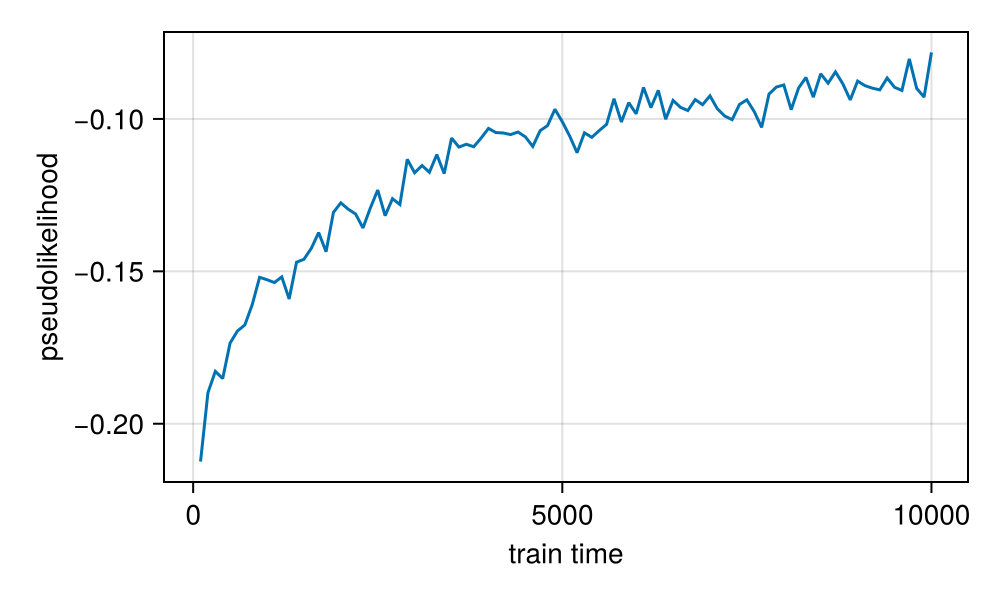

In [19]:
fig = Makie.Figure(resolution=(500,300))
ax = Makie.Axis(fig[1,1], xlabel = "train time", ylabel="pseudolikelihood")
Makie.lines!(ax, get(history, :lpl)...)
fig

In [11]:
nsteps = 3000
fantasy_F = zeros(nrows*ncols, nsteps)
fantasy_x = bitrand(28,28,nrows*ncols)
fantasy_F[:,1] .= free_energy(rbm, fantasy_x)
@time for t in 2:nsteps
    fantasy_x .= sample_v_from_v(rbm, fantasy_x)
    fantasy_F[:,t] .= free_energy(rbm, fantasy_x)
end

 30.721817 seconds (469.72 k allocations: 12.023 GiB, 1.75% gc time, 0.61% compilation time)


┌ Warning: Found `resolution` in the theme when creating a `Scene`. The `resolution` keyword for `Scene`s and `Figure`s has been deprecated. Use `Figure(; size = ...` or `Scene(; size = ...)` instead, which better reflects that this is a unitless size and not a pixel resolution. The key could also come from `set_theme!` calls or related theming functions.
└ @ Makie C:\Users\vishv\.julia\packages\Makie\6c4lt\src\scenes.jl:229


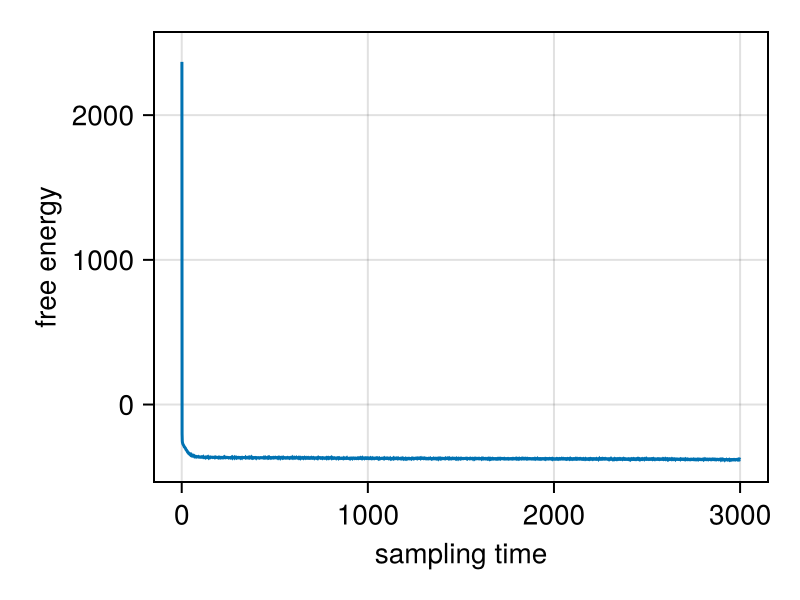

In [20]:
fig = Makie.Figure(resolution=(400,300))
ax = Makie.Axis(fig[1,1], xlabel="sampling time", ylabel="free energy")
fantasy_F_μ = vec(mean(fantasy_F; dims=1))
fantasy_F_σ = vec(std(fantasy_F; dims=1))
Makie.band!(ax, 1:nsteps, fantasy_F_μ - fantasy_F_σ/2, fantasy_F_μ + fantasy_F_σ/2)
Makie.lines!(ax, 1:nsteps, fantasy_F_μ)
fig

┌ Warning: Found `resolution` in the theme when creating a `Scene`. The `resolution` keyword for `Scene`s and `Figure`s has been deprecated. Use `Figure(; size = ...` or `Scene(; size = ...)` instead, which better reflects that this is a unitless size and not a pixel resolution. The key could also come from `set_theme!` calls or related theming functions.
└ @ Makie C:\Users\vishv\.julia\packages\Makie\6c4lt\src\scenes.jl:229


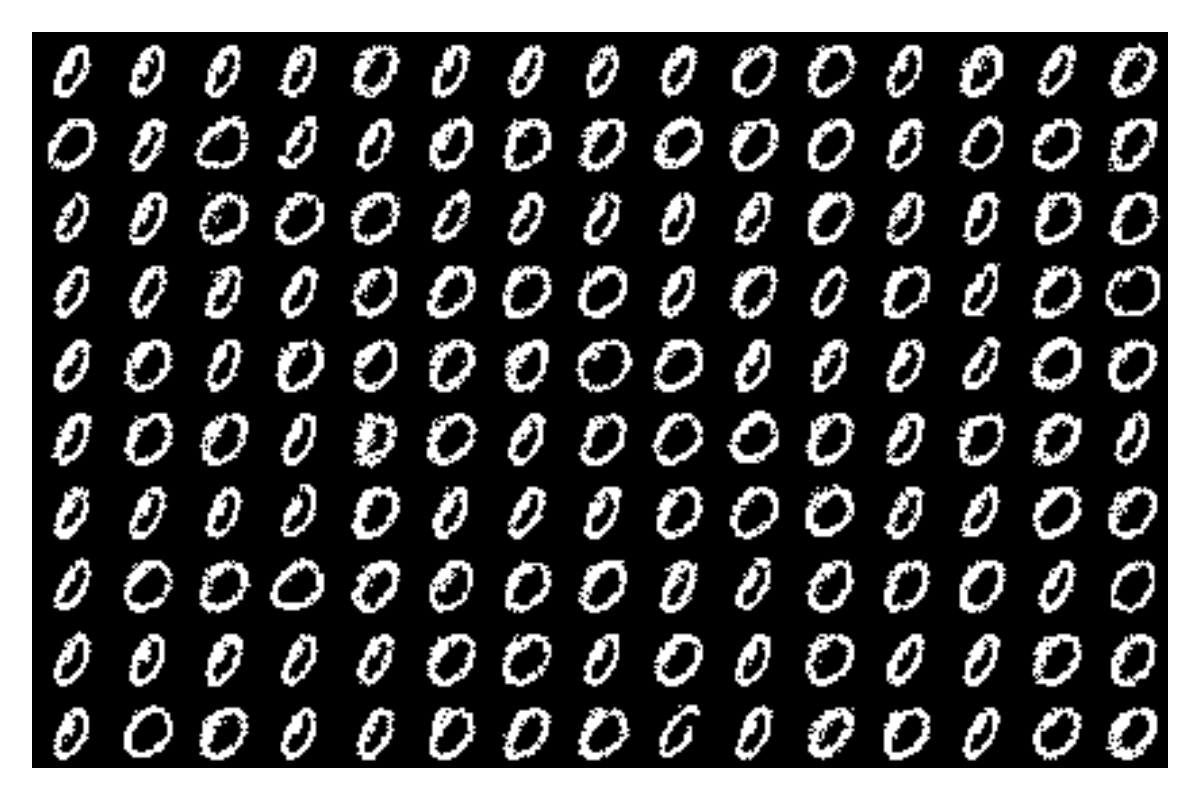

In [21]:
fig = Makie.Figure(resolution=(40ncols, 40nrows))
ax = Makie.Axis(fig[1,1], yreversed=true)
Makie.image!(ax, imggrid(reshape(fantasy_x, 28, 28, ncols, nrows)), colorrange=(1,0))
Makie.hidedecorations!(ax)
Makie.hidespines!(ax)
fig

In [107]:
fig = Makie.Figure(resolution=(500,300))
ax = Makie.Axis(fig[1,1], xlabel = "train time", ylabel="pseudolikelihood")
Makie.lines!(ax, get(history, :lpl)...)
fig

In [108]:
import RestrictedBoltzmannMachines as RBMs

In [76]:
# Get hidden unit activations (features)
hidden_features = RBMs.sample_h_from_v(rbm, train_x)


400×5923 BitMatrix:
 0  0  1  0  0  0  0  1  0  0  0  0  0  …  0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  1  0  0  0  0  0     0  0  0  0  0  0  0  0  0  1  0  1
 0  0  1  0  0  0  0  0  0  0  0  0  0     0  1  1  1  0  0  1  0  0  0  1  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  1  0  0  0  0  0  1  1  1  0  1     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0  …  0  0  0  0  1  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  1  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  1  1  1  1  1
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  1  1  0  0  0  0  0  0  0  1
 0  0  0  0  0  0  0  0  0  1  1  0  0     0  0  0  0  0  0  1  0  1  0  0  0
 ⋮              ⋮              ⋮        ⋱              ⋮              ⋮     
 0  0  0  0  0  0  0  0  1  0  0  0  0     0  0  0  0  0  0  1  0  0  0  0  0
 0  0  0  1  0  0  0  0  1  1  1  1  1     0 

In [28]:
using Statistics, MLBase, GLM, DataFrames

In [77]:
# Convert train_h to DataFrame for GLM
train_h_df = DataFrame(Float32.(transpose(hidden_features)), :auto)
train_y = train_y[train_y .== 0]
train_y_df = DataFrame(label=train_y)


Row,label
,Int64
1,0
2,0
3,0
4,0
5,0
6,0
7,0
8,0
9,0


In [80]:
# Combine features and labels into a single DataFrame
train_data = hcat(train_h_df, train_y_df)

Row,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,x14,x15,x16,x17,x18,x19,x20,x21,x22,x23,x24,x25,x26,x27,x28,x29,x30,x31,x32,x33,x34,x35,x36,x37,x38,x39,x40,x41,x42,x43,x44,x45,x46,x47,x48,x49,x50,x51,x52,x53,x54,x55,x56,x57,x58,x59,x60,x61,x62,x63,x64,x65,x66,x67,x68,x69,x70,x71,x72,x73,x74,x75,x76,x77,x78,x79,x80,x81,x82,x83,x84,x85,x86,x87,x88,x89,x90,x91,x92,x93,x94,x95,x96,x97,x98,x99,x100,⋯
,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32,⋯
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,⋯
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,⋯
3,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,⋯
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,⋯
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,⋯
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,⋯
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0

In [59]:
# Convert label to categorical
train_data.label = categorical(train_data.label)

5923-element CategoricalArray{Int64,1,UInt32}:
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 ⋮
 0
 0
 0
 0
 0
 0
 0
 0
 0

In [81]:
train_data

Row,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,x14,x15,x16,x17,x18,x19,x20,x21,x22,x23,x24,x25,x26,x27,x28,x29,x30,x31,x32,x33,x34,x35,x36,x37,x38,x39,x40,x41,x42,x43,x44,x45,x46,x47,x48,x49,x50,x51,x52,x53,x54,x55,x56,x57,x58,x59,x60,x61,x62,x63,x64,x65,x66,x67,x68,x69,x70,x71,x72,x73,x74,x75,x76,x77,x78,x79,x80,x81,x82,x83,x84,x85,x86,x87,x88,x89,x90,x91,x92,x93,x94,x95,x96,x97,x98,x99,x100,⋯
,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32,⋯
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,⋯
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,⋯
3,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,⋯
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,⋯
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,⋯
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,⋯
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0

In [72]:
feature_names = names(train_data)[1:end-1]  # Exclude the label column
formula_string = join(feature_names, " + ")


"x1 + x2 + x3 + x4 + x5 + x6 + x7 + x8 + x9 + x10 + x11 + x12 + x13 + x14 + x15 + x16 + x17 + x18 + x19 + x20 + x21 + x22 + x23 + x24 + x25 + x26 + x27 + x28 + x29 + x30 + x31 + x32 + x33 + x34 + x35 + x36 + x37 + x38 + x39 + x40 + x41 + x42 + x43 + x44 + x45 + x46 + x47" ⋯ 2149 bytes ⋯ "x362 + x363 + x364 + x365 + x366 + x367 + x368 + x369 + x370 + x371 + x372 + x373 + x374 + x375 + x376 + x377 + x378 + x379 + x380 + x381 + x382 + x383 + x384 + x385 + x386 + x387 + x388 + x389 + x390 + x391 + x392 + x393 + x394 + x395 + x396 + x397 + x398 + x399 + x400"

In [73]:
using CategoricalArrays

In [82]:
# Train a logistic regression model on the hidden features
logistic_model = glm(@formula(label ~ x1 + x2 + x3 + x4 + x5 + x6 + x7 + x8 + x9 + x10 +x11 + x12 + x13 + x14 + x15 + x16 + x17 + x18 + x19 + x20 +x21 + x22 + x23 + x24 + x25 + x26 + x27 + x28 + x29 + x30 +x31 + x32 + x33 + x34 + x35 + x36 + x37 + x38 + x39 + x40 + x41 + x42 + x43 + x44 + x45 + x46 + x47 + x48 + x49 + x50 +x51 + x52 + x53 + x54 + x55 + x56 + x57 + x58 + x59 + x60 +x61 + x62 + x63 + x64 + x65 + x66 + x67 + x68 + x69 + x70 +x71 + x72 + x73 + x74 + x75 + x76 + x77 + x78 + x79 + x80 +x81 + x82 + x83 + x84 + x85 + x86 + x87 + x88 + x89 + x90 +x91 + x92 + x93 + x94 + x95 + x96 + x97 + x98 + x99 + x100 +x101 + x102 + x103 + x104 + x105 + x106 + x107 + x108 + x109 +x110 + x111 + x112 + x113 + x114 + x115 + x116 + x117 + x118 +x119 + x120 + x121 + x122 + x123 + x124 + x125 + x126 + x127 +x128 + x129 + x130 + x131 + x132 + x133 + x134 + x135 + x136 +x137 + x138 + x139 + x140 + x141 + x142 + x143 + x144 + x145 +x146 + x147 + x148 + x149 + x150 + x151 + x152 + x153 + x154 + x155 + x156 + x157 + x158 + x159 + x160 + x161 + x162 + x163 +x164 + x165 + x166 + x167 + x168 + x169 + x170 + x171 + x172 +x173 + x174 + x175 + x176 + x177 + x178 + x179 + x180 + x181 +x182 + x183 + x184 + x185 + x186 + x187 + x188 + x189 + x190 +x191 + x192 + x193 + x194 + x195 + x196 + x197 + x198 + x199 +x200 + x201 + x202 + x203 + x204 + x205 + x206 + x207 + x208 +x209 + x210 + x211 + x212 + x213 + x214 + x215 + x216 + x217 +x218 + x219 + x220 + x221 + x222 + x223 + x224 + x225 + x226 +x227 + x228 + x229 + x230 + x231 + x232 + x233 + x234 + x235 +x236 + x237 + x238 + x239 + x240 + x241 + x242 + x243 + x244 +x245 + x246 + x247 + x248 + x249 + x250 + x251 + x252 + x253 +x254 + x255 + x256 + x257 + x258 + x259 + x260 + x261 + x262 +x263 + x264 + x265 + x266 + x267 + x268 + x269 + x270 + x271 + x272 + x273 + x274 + x275 + x276 + x277 + x278 + x279 + x280 +x281 + x282 + x283 + x284 + x285 + x286 + x287 + x288 + x289 +x290 + x291 + x292 + x293 + x294 + x295 + x296 + x297 + x298 + x299 + x300 + x301 + x302 + x303 + x304 + x305 + x306 + x307 + x308 + x309 + x310 + x311 + x312 + x313 + x314 + x315 + x316 +x317 + x318 + x319 + x320 + x321 + x322 + x323 + x324 + x325 + x326 + x327 + x328 + x329 + x330 + x331 + x332 + x333 + x334 + x335 + x336 + x337 + x338 + x339 + x340 + x341 + x342 + x343 +x344 + x345 + x346 + x347 + x348 + x349 + x350 + x351 + x352 + x353 + x354 + x355 + x356 + x357 + x358 + x359 + x360 + x361 +x362 + x363 + x364 + x365 + x366 + x367 + x368 + x369 + x370 +x371 + x372 + x373 + x374 + x375 + x376 + x377 + x378 + x379 + x380 + x381 + x382 + x383 + x384 + x385 + x386 + x387 + x388 + x389 + x390 + x391 + x392 + x393 + x394 + x395 + x396 + x397 + x398 + x399 + x400), train_data, Binomial())

StatsModels.TableRegressionModel{GeneralizedLinearModel{GLM.GlmResp{Vector{Float64}, Binomial{Float64}, LogitLink}, GLM.DensePredChol{Float64, LinearAlgebra.CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

label ~ 1 + x1 + x2 + x3 + x4 + x5 + x6 + x7 + x8 + x9 + x10 + x11 + x12 + x13 + x14 + x15 + x16 + x17 + x18 + x19 + x20 + x21 + x22 + x23 + x24 + x25 + x26 + x27 + x28 + x29 + x30 + x31 + x32 + x33 + x34 + x35 + x36 + x37 + x38 + x39 + x40 + x41 + x42 + x43 + x44 + x45 + x46 + x47 + x48 + x49 + x50 + x51 + x52 + x53 + x54 + x55 + x56 + x57 + x58 + x59 + x60 + x61 + x62 + x63 + x64 + x65 + x66 + x67 + x68 + x69 + x70 + x71 + x72 + x73 + x74 + x75 + x76 + x77 + x78 + x79 + x80 + x81 + x82 + x83 + x84 + x85 + x86 + x87 + x88 + x89 + x90 + x91 + x92 + x93 + x94 + x95 + x96 + x97 + x98 + x99 + x100 + x101 + x102 + x103 + x104 + x105 + x106 + x107 + x108 + x109 + x110 + x111 + x112 + x113 + x114 + x115 + x116 + x117 + x118 + x119 + x120 + x121 + x122 + x123 + 

In [97]:
Float = Float32
test_x = MLDatasets.MNIST(split=:test)[:].features
test_y = MLDatasets.MNIST(split=:test)[:].targets
test_x = Array{Float}(test_x[:, :, test_y .== 0] .≥ 0.5)

28×28×980 Array{Float32, 3}:
[:, :, 1] =
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     1.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     1.0  1.0  0.0  0.0  0.0  0.0  0.0
 ⋮                        ⋮              ⋱                      ⋮         
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  

In [98]:
# Get hidden unit activations (features)
test_h = RBMs.sample_h_from_v(rbm, test_x)


400×980 BitMatrix:
 0  0  0  0  0  1  0  0  0  0  0  0  0  …  0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  1  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  1  0  0
 0  0  0  0  0  1  0  0  0  1  1  0  1     0  0  1  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  1  0  0  0     0  0  0  1  0  0  0  0  0  0  0  0
 0  0  0  0  1  1  0  0  0  0  1  1  1     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0  …  0  0  0  0  1  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  1  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  1  0  0  0  0  1  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  1  0  1  0  0  0  0  0  0  0
 0  0  0  0  0  0  1  0  0  0  0  0  0     0  0  0  0  0  1  1  1  0  0  0  0
 ⋮              ⋮              ⋮        ⋱        ⋮              ⋮           
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 1  0  1  0  1  1  0  0  1  0  1  1  1     0  

In [99]:
# Convert test_h to DataFrame
test_h_df = DataFrame(transpose(Float32.(test_h)), :auto)  # Convert features to Float32

test_y = test_y[test_y .== 0]
test_y_df = DataFrame(label=test_y)

# Make predictions
predictions = predict(logistic_model, test_h_df)

# Since predictions give probabilities, we need to convert them to binary labels
pred_labels = predictions .> 0.5  # Set threshold for binary classification

980-element BitVector:
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 ⋮
 0
 0
 0
 0
 0
 0
 0
 0
 0

In [100]:
# Evaluate the classifier
accuracy = mean(pred_labels .== test_y)
println("Test Accuracy: ", accuracy)

Test Accuracy: 1.0


In [106]:
test_x = MLDatasets.MNIST(split=:test)[:].features
test_y = MLDatasets.MNIST(split=:test)[:].targets
test_x = Array{Float32}(test_x .≥ 0.5)

# Extract features from the test set
test_h = RBMs.sample_h_from_v(rbm, test_x)

# Convert test_h to DataFrame
test_h_df = DataFrame(Float32.(transpose(test_h)), :auto)  # Convert features to Float32

# Make predictions
predictions = predict(logistic_model, test_h_df)

# Since predictions give probabilities, we need to convert them to binary labels
pred_labels = predictions .> 0.5  # Set threshold for binary classification

# Evaluate the classifier
accuracy = mean(pred_labels .== test_y)
println("Test Accuracy: ", accuracy)

Test Accuracy: 0.098


For Digit 1

In [110]:
Float = Float32
train_x = MLDatasets.MNIST(split=:train)[:].features
train_y = MLDatasets.MNIST(split=:train)[:].targets
train_x = Array{Float}(train_x[:, :, train_y .== 1] .≥ 0.5)

28×28×6742 Array{Float32, 3}:
[:, :, 1] =
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     1.0  1.0  1.0  1.0  0.0  0.0  0.0
 ⋮                        ⋮              ⋱                      ⋮         
 0.0  0.0  0.0  0.0  0.0  1.0  1.0  1.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0 

┌ Warning: Found `resolution` in the theme when creating a `Scene`. The `resolution` keyword for `Scene`s and `Figure`s has been deprecated. Use `Figure(; size = ...` or `Scene(; size = ...)` instead, which better reflects that this is a unitless size and not a pixel resolution. The key could also come from `set_theme!` calls or related theming functions.
└ @ Makie C:\Users\vishv\.julia\packages\Makie\6c4lt\src\scenes.jl:229


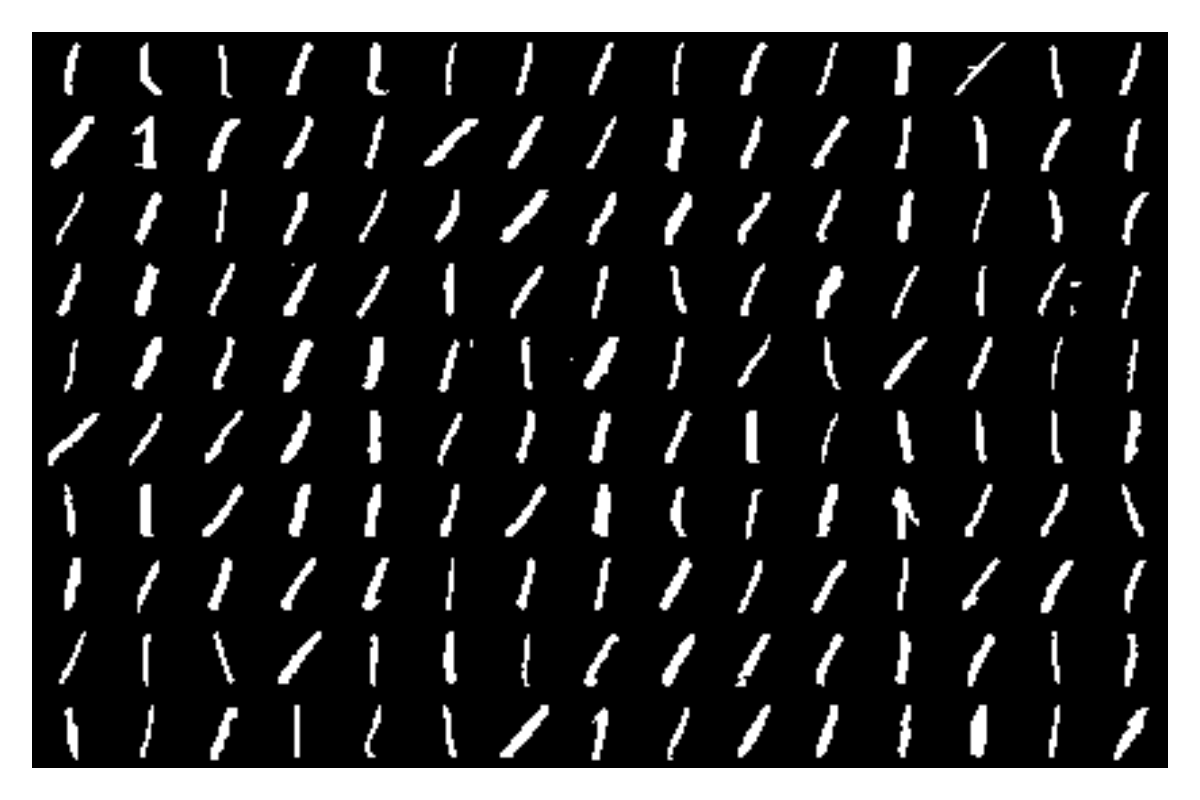

In [111]:
nrows, ncols = 10, 15
fig = Makie.Figure(resolution=(40ncols, 40nrows))
ax = Makie.Axis(fig[1,1], yreversed=true)
idx = rand(1:size(train_x,3), nrows * ncols) # random indices of digits
digits = reshape(train_x[:,:,idx], 28, 28, ncols, nrows)
Makie.image!(ax, imggrid(digits), colorrange=(1,0))
Makie.hidedecorations!(ax)
Makie.hidespines!(ax)
fig

In [113]:
println("log(PL) = ", mean(@time log_pseudolikelihood(rbm, train_x)))

  0.561113 seconds (20.39 k allocations: 62.483 MiB)
log(PL) = -0.14888681


In [114]:
batchsize = 256
iters = 10000
history = MVHistory()
@time pcd!(
    rbm, train_x; iters, batchsize,
    callback = function(; iter, _...)
        if iszero(iter % 100)
            lpl = mean(log_pseudolikelihood(rbm, train_x))
            @trace history iter lpl
        end
    end
)

518.898103 seconds (5.59 M allocations: 205.689 GiB, 18.44% gc time, 0.25% compilation time)


((visible = Leaf(Adam{Float32}(0.001, (0.9, 0.999), 1.19209f-7), (Float32[0.0 0.0 … 6.0f-45 0.0;;; 6.0f-45 0.0 … 6.0f-45 0.0;;; 5.39643f-31 0.0 … 0.0 6.0f-45;;; … ;;; 6.0f-45 0.0 … 6.0f-45 0.0;;; 6.0f-45 0.0 … 6.0f-45 6.0f-45;;; 6.0f-45 6.0f-45 … 6.0f-45 6.0f-45], Float32[0.0 0.0 … 7.68858f-11 0.0;;; 7.44576f-13 0.0 … 4.71253f-10 0.0;;; 8.48123f-9 0.0 … 0.0 5.33356f-12;;; … ;;; 1.01337f-10 0.0 … 2.89311f-9 0.0;;; 9.15898f-10 0.0 … 1.51126f-11 1.86273f-11;;; 8.74778f-11 5.3045f-11 … 5.8361f-12 2.12052f-10], (6.0f-45, 4.5134f-5))), hidden = Leaf(Adam{Float32}(0.001, (0.9, 0.999), 1.19209f-7), (Float32[-0.00951794 -0.00161517 … 0.0296553 0.0132441], Float32[0.00166135 0.000104412 … 0.00223279 0.000225807], (6.0f-45, 4.5134f-5))), w = Leaf(Adam{Float32}(0.001, (0.9, 0.999), 1.19209f-7), (Float32[0.0 6.0f-45 … 6.0f-45 6.0f-45; 0.0 0.0 … 0.0 6.0f-45; … ; 6.0f-45 6.0f-45 … 6.0f-45 6.0f-45; 0.0 0.0 … 6.0f-45 6.0f-45;;; 0.0 6.0f-45 … 6.0f-45 6.0f-45; 0.0 0.0 … 0.0 6.0f-45; … ; 6.0f-45 6.0f-45 …

┌ Warning: Found `resolution` in the theme when creating a `Scene`. The `resolution` keyword for `Scene`s and `Figure`s has been deprecated. Use `Figure(; size = ...` or `Scene(; size = ...)` instead, which better reflects that this is a unitless size and not a pixel resolution. The key could also come from `set_theme!` calls or related theming functions.
└ @ Makie C:\Users\vishv\.julia\packages\Makie\6c4lt\src\scenes.jl:229


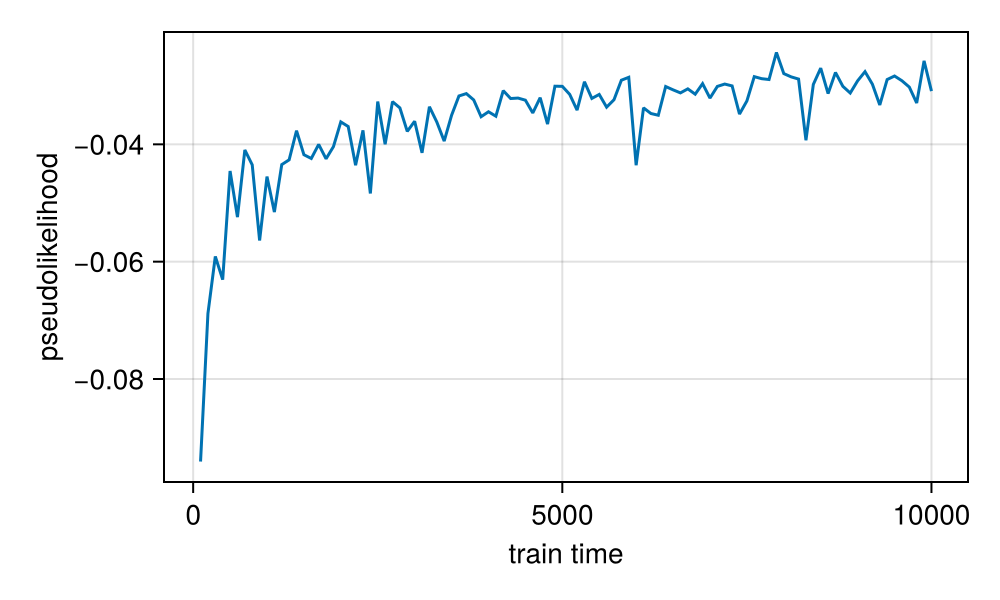

In [115]:
fig = Makie.Figure(resolution=(500,300))
ax = Makie.Axis(fig[1,1], xlabel = "train time", ylabel="pseudolikelihood")
Makie.lines!(ax, get(history, :lpl)...)
fig

In [116]:
nsteps = 3000
fantasy_F = zeros(nrows*ncols, nsteps)
fantasy_x = bitrand(28,28,nrows*ncols)
fantasy_F[:,1] .= free_energy(rbm, fantasy_x)
@time for t in 2:nsteps
    fantasy_x .= sample_v_from_v(rbm, fantasy_x)
    fantasy_F[:,t] .= free_energy(rbm, fantasy_x)
end

 36.971480 seconds (450.81 k allocations: 12.022 GiB, 3.23% gc time)


┌ Warning: Found `resolution` in the theme when creating a `Scene`. The `resolution` keyword for `Scene`s and `Figure`s has been deprecated. Use `Figure(; size = ...` or `Scene(; size = ...)` instead, which better reflects that this is a unitless size and not a pixel resolution. The key could also come from `set_theme!` calls or related theming functions.
└ @ Makie C:\Users\vishv\.julia\packages\Makie\6c4lt\src\scenes.jl:229


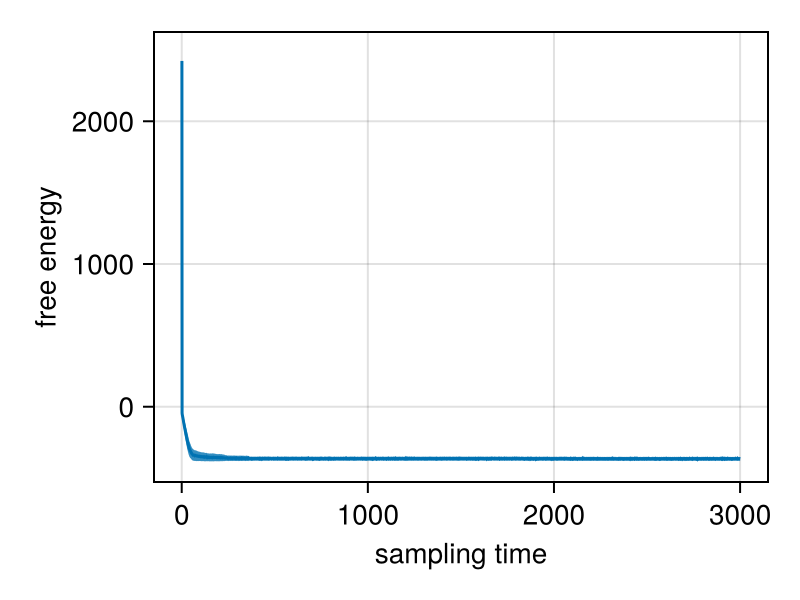

In [117]:
fig = Makie.Figure(resolution=(400,300))
ax = Makie.Axis(fig[1,1], xlabel="sampling time", ylabel="free energy")
fantasy_F_μ = vec(mean(fantasy_F; dims=1))
fantasy_F_σ = vec(std(fantasy_F; dims=1))
Makie.band!(ax, 1:nsteps, fantasy_F_μ - fantasy_F_σ/2, fantasy_F_μ + fantasy_F_σ/2)
Makie.lines!(ax, 1:nsteps, fantasy_F_μ)
fig

┌ Warning: Found `resolution` in the theme when creating a `Scene`. The `resolution` keyword for `Scene`s and `Figure`s has been deprecated. Use `Figure(; size = ...` or `Scene(; size = ...)` instead, which better reflects that this is a unitless size and not a pixel resolution. The key could also come from `set_theme!` calls or related theming functions.
└ @ Makie C:\Users\vishv\.julia\packages\Makie\6c4lt\src\scenes.jl:229


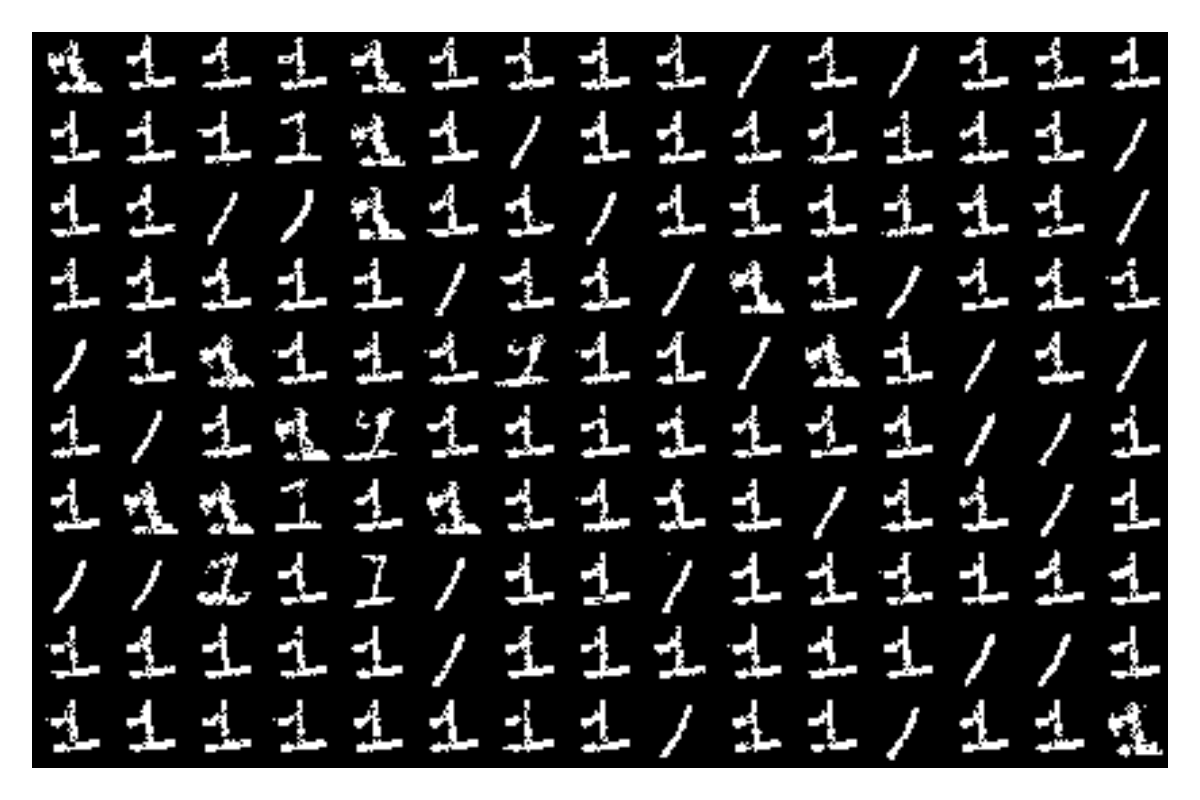

In [118]:
fig = Makie.Figure(resolution=(40ncols, 40nrows))
ax = Makie.Axis(fig[1,1], yreversed=true)
Makie.image!(ax, imggrid(reshape(fantasy_x, 28, 28, ncols, nrows)), colorrange=(1,0))
Makie.hidedecorations!(ax)
Makie.hidespines!(ax)
fig

In [120]:
for i in 2:9
    println("For Digit $i")
    #loading dataset
    Float = Float32
    train_x = MLDatasets.MNIST(split=:train)[:].features
    train_y = MLDatasets.MNIST(split=:train)[:].targets
    train_x = Array{Float}(train_x[:, :, train_y .== i] .≥ 0.5)
    #showing original images
    nrows, ncols = 10, 15
    fig = Makie.Figure(resolution=(40ncols, 40nrows))
    ax = Makie.Axis(fig[1,1], yreversed=true)
    idx = rand(1:size(train_x,3), nrows * ncols) # random indices of digits
    digits = reshape(train_x[:,:,idx], 28, 28, ncols, nrows)
    Makie.image!(ax, imggrid(digits), colorrange=(1,0))
    Makie.hidedecorations!(ax)
    Makie.hidespines!(ax)
    fig
    #printing initial log_pseudolikelihood
    println("log(PL) = ", mean(@time log_pseudolikelihood(rbm, train_x)))
    #training
    batchsize = 256
    iters = 10000
    history = MVHistory()
    @time pcd!(
        rbm, train_x; iters, batchsize,
        callback = function(; iter, _...)
            if iszero(iter % 100)
                lpl = mean(log_pseudolikelihood(rbm, train_x))
                @trace history iter lpl
            end
        end
    )
    #observing change of pseudolikelihood
    fig = Makie.Figure(resolution=(500,300))
    ax = Makie.Axis(fig[1,1], xlabel = "train time", ylabel="pseudolikelihood")
    Makie.lines!(ax, get(history, :lpl)...)
    fig
    #observing free energy
    nsteps = 3000
    fantasy_F = zeros(nrows*ncols, nsteps)
    fantasy_x = bitrand(28,28,nrows*ncols)
    fantasy_F[:,1] .= free_energy(rbm, fantasy_x)
    @time for t in 2:nsteps
        fantasy_x .= sample_v_from_v(rbm, fantasy_x)
        fantasy_F[:,t] .= free_energy(rbm, fantasy_x)
    end
    fig = Makie.Figure(resolution=(400,300))
    ax = Makie.Axis(fig[1,1], xlabel="sampling time", ylabel="free energy")
    fantasy_F_μ = vec(mean(fantasy_F; dims=1))
    fantasy_F_σ = vec(std(fantasy_F; dims=1))
    Makie.band!(ax, 1:nsteps, fantasy_F_μ - fantasy_F_σ/2, fantasy_F_μ + fantasy_F_σ/2)
    Makie.lines!(ax, 1:nsteps, fantasy_F_μ)
    fig
    #generating sample images
    fig = Makie.Figure(resolution=(40ncols, 40nrows))
    ax = Makie.Axis(fig[1,1], yreversed=true)
    Makie.image!(ax, imggrid(reshape(fantasy_x, 28, 28, ncols, nrows)), colorrange=(1,0))
    Makie.hidedecorations!(ax)
    Makie.hidespines!(ax)
    fig
end


For Digit 2


┌ Warning: Found `resolution` in the theme when creating a `Scene`. The `resolution` keyword for `Scene`s and `Figure`s has been deprecated. Use `Figure(; size = ...` or `Scene(; size = ...)` instead, which better reflects that this is a unitless size and not a pixel resolution. The key could also come from `set_theme!` calls or related theming functions.
└ @ Makie C:\Users\vishv\.julia\packages\Makie\6c4lt\src\scenes.jl:229


  0.323471 seconds (18.04 k allocations: 55.219 MiB)
log(PL) = -0.24541722
426.032264 seconds (5.36 M allocations: 204.968 GiB, 18.44% gc time, 0.70% compilation time)


┌ Warning: Found `resolution` in the theme when creating a `Scene`. The `resolution` keyword for `Scene`s and `Figure`s has been deprecated. Use `Figure(; size = ...` or `Scene(; size = ...)` instead, which better reflects that this is a unitless size and not a pixel resolution. The key could also come from `set_theme!` calls or related theming functions.
└ @ Makie C:\Users\vishv\.julia\packages\Makie\6c4lt\src\scenes.jl:229


 30.923454 seconds (450.82 k allocations: 12.022 GiB, 2.59% gc time)
For Digit 3

┌ Warning: Found `resolution` in the theme when creating a `Scene`. The `resolution` keyword for `Scene`s and `Figure`s has been deprecated. Use `Figure(; size = ...` or `Scene(; size = ...)` instead, which better reflects that this is a unitless size and not a pixel resolution. The key could also come from `set_theme!` calls or related theming functions.
└ @ Makie C:\Users\vishv\.julia\packages\Makie\6c4lt\src\scenes.jl:229
┌ Warning: Found `resolution` in the theme when creating a `Scene`. The `resolution` keyword for `Scene`s and `Figure`s has been deprecated. Use `Figure(; size = ...` or `Scene(; size = ...)` instead, which better reflects that this is a unitless size and not a pixel resolution. The key could also come from `set_theme!` calls or related theming functions.
└ @ Makie C:\Users\vishv\.julia\packages\Makie\6c4lt\src\scenes.jl:229


┌ Warning: Found `resolution` in the theme when creating a `Scene`. The `resolution` keyword for `Scene`s and `Figure`s has been deprecated. Use `Figure(; size = ...` or `Scene(; size = ...)` instead, which better reflects that this is a unitless size and not a pixel resolution. The key could also come from `set_theme!` calls or related theming functions.
└ @ Makie C:\Users\vishv\.julia\packages\Makie\6c4lt\src\scenes.jl:229


  0.143883 seconds (18.56 k allocations: 56.822 MiB)
log(PL) = -0.16367193
385.444674 seconds (5.25 M allocations: 205.335 GiB, 12.53% gc time)


┌ Warning: Found `resolution` in the theme when creating a `Scene`. The `resolution` keyword for `Scene`s and `Figure`s has been deprecated. Use `Figure(; size = ...` or `Scene(; size = ...)` instead, which better reflects that this is a unitless size and not a pixel resolution. The key could also come from `set_theme!` calls or related theming functions.
└ @ Makie C:\Users\vishv\.julia\packages\Makie\6c4lt\src\scenes.jl:229


 31.189664 seconds (450.82 k allocations: 12.022 GiB, 2.77% gc time)
For Digit 4


┌ Warning: Found `resolution` in the theme when creating a `Scene`. The `resolution` keyword for `Scene`s and `Figure`s has been deprecated. Use `Figure(; size = ...` or `Scene(; size = ...)` instead, which better reflects that this is a unitless size and not a pixel resolution. The key could also come from `set_theme!` calls or related theming functions.
└ @ Makie C:\Users\vishv\.julia\packages\Makie\6c4lt\src\scenes.jl:229
┌ Warning: Found `resolution` in the theme when creating a `Scene`. The `resolution` keyword for `Scene`s and `Figure`s has been deprecated. Use `Figure(; size = ...` or `Scene(; size = ...)` instead, which better reflects that this is a unitless size and not a pixel resolution. The key could also come from `set_theme!` calls or related theming functions.
└ @ Makie C:\Users\vishv\.julia\packages\Makie\6c4lt\src\scenes.jl:229
┌ Warning: Found `resolution` in the theme when creating a `Scene`. The `resolution` keyword for `Scene`s and `Figure`s has been deprecated. U

  0.169476 seconds (17.70 k allocations: 54.144 MiB)
log(PL) = -0.16360562
348.859098 seconds (5.16 M allocations: 205.048 GiB, 8.20% gc time)


┌ Warning: Found `resolution` in the theme when creating a `Scene`. The `resolution` keyword for `Scene`s and `Figure`s has been deprecated. Use `Figure(; size = ...` or `Scene(; size = ...)` instead, which better reflects that this is a unitless size and not a pixel resolution. The key could also come from `set_theme!` calls or related theming functions.
└ @ Makie C:\Users\vishv\.julia\packages\Makie\6c4lt\src\scenes.jl:229


 31.191721 seconds (450.82 k allocations: 12.022 GiB, 2.61% gc time)
For Digit 5

┌ Warning: Found `resolution` in the theme when creating a `Scene`. The `resolution` keyword for `Scene`s and `Figure`s has been deprecated. Use `Figure(; size = ...` or `Scene(; size = ...)` instead, which better reflects that this is a unitless size and not a pixel resolution. The key could also come from `set_theme!` calls or related theming functions.
└ @ Makie C:\Users\vishv\.julia\packages\Makie\6c4lt\src\scenes.jl:229
┌ Warning: Found `resolution` in the theme when creating a `Scene`. The `resolution` keyword for `Scene`s and `Figure`s has been deprecated. Use `Figure(; size = ...` or `Scene(; size = ...)` instead, which better reflects that this is a unitless size and not a pixel resolution. The key could also come from `set_theme!` calls or related theming functions.
└ @ Makie C:\Users\vishv\.julia\packages\Makie\6c4lt\src\scenes.jl:229


┌ Warning: Found `resolution` in the theme when creating a `Scene`. The `resolution` keyword for `Scene`s and `Figure`s has been deprecated. Use `Figure(; size = ...` or `Scene(; size = ...)` instead, which better reflects that this is a unitless size and not a pixel resolution. The key could also come from `set_theme!` calls or related theming functions.
└ @ Makie C:\Users\vishv\.julia\packages\Makie\6c4lt\src\scenes.jl:229


  0.178893 seconds (16.43 k allocations: 50.243 MiB)
log(PL) = -0.20189826
372.618340 seconds (5.04 M allocations: 204.455 GiB, 11.36% gc time)


┌ Warning: Found `resolution` in the theme when creating a `Scene`. The `resolution` keyword for `Scene`s and `Figure`s has been deprecated. Use `Figure(; size = ...` or `Scene(; size = ...)` instead, which better reflects that this is a unitless size and not a pixel resolution. The key could also come from `set_theme!` calls or related theming functions.
└ @ Makie C:\Users\vishv\.julia\packages\Makie\6c4lt\src\scenes.jl:229


 30.615392 seconds (450.82 k allocations: 12.022 GiB, 2.57% gc time)


┌ Warning: Found `resolution` in the theme when creating a `Scene`. The `resolution` keyword for `Scene`s and `Figure`s has been deprecated. Use `Figure(; size = ...` or `Scene(; size = ...)` instead, which better reflects that this is a unitless size and not a pixel resolution. The key could also come from `set_theme!` calls or related theming functions.
└ @ Makie C:\Users\vishv\.julia\packages\Makie\6c4lt\src\scenes.jl:229
┌ Warning: Found `resolution` in the theme when creating a `Scene`. The `resolution` keyword for `Scene`s and `Figure`s has been deprecated. Use `Figure(; size = ...` or `Scene(; size = ...)` instead, which better reflects that this is a unitless size and not a pixel resolution. The key could also come from `set_theme!` calls or related theming functions.
└ @ Makie C:\Users\vishv\.julia\packages\Makie\6c4lt\src\scenes.jl:229


For Digit 6


┌ Warning: Found `resolution` in the theme when creating a `Scene`. The `resolution` keyword for `Scene`s and `Figure`s has been deprecated. Use `Figure(; size = ...` or `Scene(; size = ...)` instead, which better reflects that this is a unitless size and not a pixel resolution. The key could also come from `set_theme!` calls or related theming functions.
└ @ Makie C:\Users\vishv\.julia\packages\Makie\6c4lt\src\scenes.jl:229


  0.223275 seconds (18.00 k allocations: 54.854 MiB, 25.22% gc time)
log(PL) = -0.15011255
364.873875 seconds (5.18 M allocations: 204.871 GiB, 10.83% gc time)


┌ Warning: Found `resolution` in the theme when creating a `Scene`. The `resolution` keyword for `Scene`s and `Figure`s has been deprecated. Use `Figure(; size = ...` or `Scene(; size = ...)` instead, which better reflects that this is a unitless size and not a pixel resolution. The key could also come from `set_theme!` calls or related theming functions.
└ @ Makie C:\Users\vishv\.julia\packages\Makie\6c4lt\src\scenes.jl:229


 29.450192 seconds (450.82 k allocations: 12.022 GiB, 2.82% gc time)
For Digit 7


┌ Warning: Found `resolution` in the theme when creating a `Scene`. The `resolution` keyword for `Scene`s and `Figure`s has been deprecated. Use `Figure(; size = ...` or `Scene(; size = ...)` instead, which better reflects that this is a unitless size and not a pixel resolution. The key could also come from `set_theme!` calls or related theming functions.
└ @ Makie C:\Users\vishv\.julia\packages\Makie\6c4lt\src\scenes.jl:229
┌ Warning: Found `resolution` in the theme when creating a `Scene`. The `resolution` keyword for `Scene`s and `Figure`s has been deprecated. Use `Figure(; size = ...` or `Scene(; size = ...)` instead, which better reflects that this is a unitless size and not a pixel resolution. The key could also come from `set_theme!` calls or related theming functions.
└ @ Makie C:\Users\vishv\.julia\packages\Makie\6c4lt\src\scenes.jl:229
┌ Warning: Found `resolution` in the theme when creating a `Scene`. The `resolution` keyword for `Scene`s and `Figure`s has been deprecated. U

  0.188865 seconds (18.96 k allocations: 58.064 MiB)
log(PL) = -0.25910074
348.217191 seconds (5.29 M allocations: 205.297 GiB, 10.21% gc time)


┌ Warning: Found `resolution` in the theme when creating a `Scene`. The `resolution` keyword for `Scene`s and `Figure`s has been deprecated. Use `Figure(; size = ...` or `Scene(; size = ...)` instead, which better reflects that this is a unitless size and not a pixel resolution. The key could also come from `set_theme!` calls or related theming functions.
└ @ Makie C:\Users\vishv\.julia\packages\Makie\6c4lt\src\scenes.jl:229


 29.097673 seconds (450.82 k allocations: 12.022 GiB, 2.57% gc time)
For Digit 8

┌ Warning: Found `resolution` in the theme when creating a `Scene`. The `resolution` keyword for `Scene`s and `Figure`s has been deprecated. Use `Figure(; size = ...` or `Scene(; size = ...)` instead, which better reflects that this is a unitless size and not a pixel resolution. The key could also come from `set_theme!` calls or related theming functions.
└ @ Makie C:\Users\vishv\.julia\packages\Makie\6c4lt\src\scenes.jl:229
┌ Warning: Found `resolution` in the theme when creating a `Scene`. The `resolution` keyword for `Scene`s and `Figure`s has been deprecated. Use `Figure(; size = ...` or `Scene(; size = ...)` instead, which better reflects that this is a unitless size and not a pixel resolution. The key could also come from `set_theme!` calls or related theming functions.
└ @ Makie C:\Users\vishv\.julia\packages\Makie\6c4lt\src\scenes.jl:229


┌ Warning: Found `resolution` in the theme when creating a `Scene`. The `resolution` keyword for `Scene`s and `Figure`s has been deprecated. Use `Figure(; size = ...` or `Scene(; size = ...)` instead, which better reflects that this is a unitless size and not a pixel resolution. The key could also come from `set_theme!` calls or related theming functions.
└ @ Makie C:\Users\vishv\.julia\packages\Makie\6c4lt\src\scenes.jl:229


  0.208817 seconds (17.72 k allocations: 54.228 MiB)
log(PL) = -0.19487454
345.563698 seconds (5.16 M allocations: 205.068 GiB, 13.73% gc time)


┌ Warning: Found `resolution` in the theme when creating a `Scene`. The `resolution` keyword for `Scene`s and `Figure`s has been deprecated. Use `Figure(; size = ...` or `Scene(; size = ...)` instead, which better reflects that this is a unitless size and not a pixel resolution. The key could also come from `set_theme!` calls or related theming functions.
└ @ Makie C:\Users\vishv\.julia\packages\Makie\6c4lt\src\scenes.jl:229


 28.036402 seconds (450.82 k allocations: 12.022 GiB, 2.26% gc time)
For Digit 9


┌ Warning: Found `resolution` in the theme when creating a `Scene`. The `resolution` keyword for `Scene`s and `Figure`s has been deprecated. Use `Figure(; size = ...` or `Scene(; size = ...)` instead, which better reflects that this is a unitless size and not a pixel resolution. The key could also come from `set_theme!` calls or related theming functions.
└ @ Makie C:\Users\vishv\.julia\packages\Makie\6c4lt\src\scenes.jl:229
┌ Warning: Found `resolution` in the theme when creating a `Scene`. The `resolution` keyword for `Scene`s and `Figure`s has been deprecated. Use `Figure(; size = ...` or `Scene(; size = ...)` instead, which better reflects that this is a unitless size and not a pixel resolution. The key could also come from `set_theme!` calls or related theming functions.
└ @ Makie C:\Users\vishv\.julia\packages\Makie\6c4lt\src\scenes.jl:229
┌ Warning: Found `resolution` in the theme when creating a `Scene`. The `resolution` keyword for `Scene`s and `Figure`s has been deprecated. U

  0.187001 seconds (18.02 k allocations: 55.136 MiB)
log(PL) = -0.120075494
330.254371 seconds (5.19 M allocations: 204.939 GiB, 16.33% gc time)
 22.452299 seconds (450.82 k allocations: 12.022 GiB, 2.31% gc time)


┌ Warning: Found `resolution` in the theme when creating a `Scene`. The `resolution` keyword for `Scene`s and `Figure`s has been deprecated. Use `Figure(; size = ...` or `Scene(; size = ...)` instead, which better reflects that this is a unitless size and not a pixel resolution. The key could also come from `set_theme!` calls or related theming functions.
└ @ Makie C:\Users\vishv\.julia\packages\Makie\6c4lt\src\scenes.jl:229
┌ Warning: Found `resolution` in the theme when creating a `Scene`. The `resolution` keyword for `Scene`s and `Figure`s has been deprecated. Use `Figure(; size = ...` or `Scene(; size = ...)` instead, which better reflects that this is a unitless size and not a pixel resolution. The key could also come from `set_theme!` calls or related theming functions.
└ @ Makie C:\Users\vishv\.julia\packages\Makie\6c4lt\src\scenes.jl:229
┌ Warning: Found `resolution` in the theme when creating a `Scene`. The `resolution` keyword for `Scene`s and `Figure`s has been deprecated. U

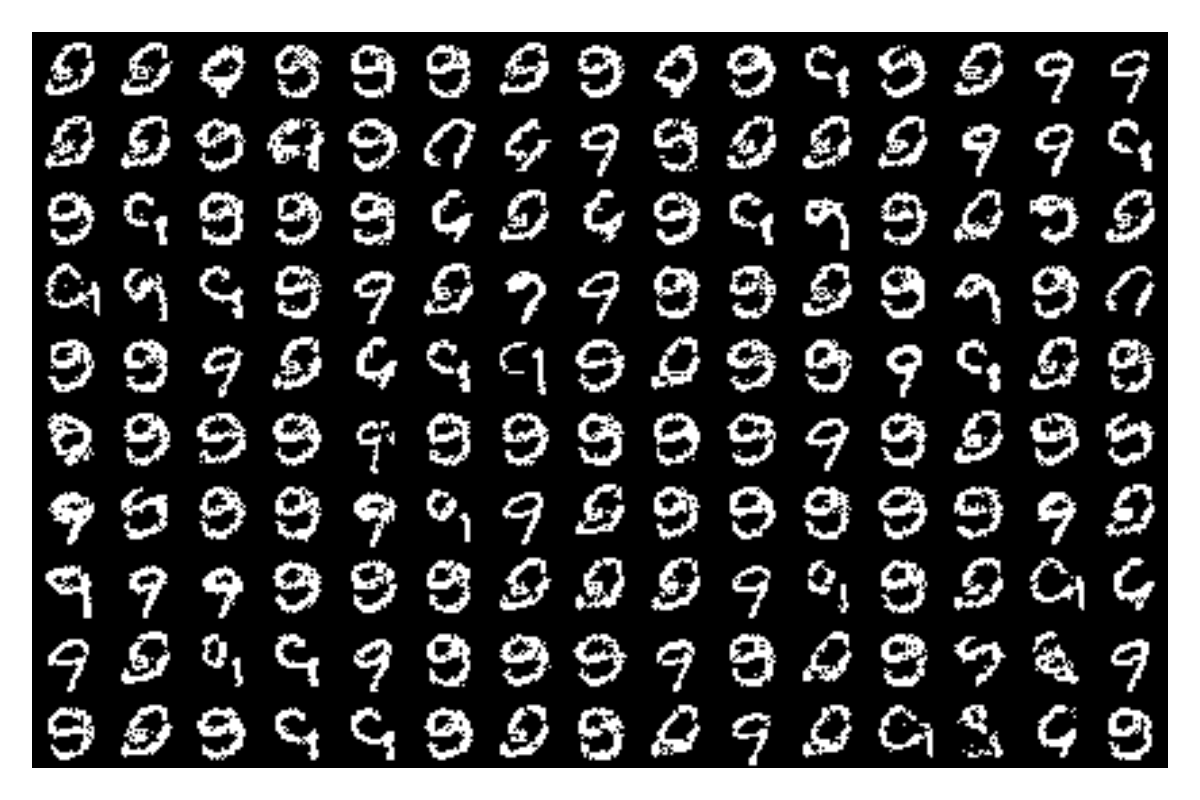

In [121]:
fig

In [122]:
rbm

RestrictedBoltzmannMachines.RBM{RestrictedBoltzmannMachines.Binary{2, Array{Float32, 3}}, RestrictedBoltzmannMachines.Binary{1, Matrix{Float32}}, Array{Float32, 3}}(RestrictedBoltzmannMachines.Binary{2, Array{Float32, 3}}(Float32[-13.972129 -13.968744 … -13.875596 -13.957686;;; -13.946976 -13.984151 … -14.015561 -13.957495;;; -13.951729 -13.935294 … -13.999599 -13.93989;;; … ;;; -14.017142 -13.938324 … -13.963317 -13.932952;;; -13.993273 -13.963931 … -14.007511 -14.022489;;; -13.938913 -13.93507 … -13.920437 -13.921337]), RestrictedBoltzmannMachines.Binary{1, Matrix{Float32}}(Float32[-1.1177336 -0.2614582 … 1.0060894 -1.811588]), Float32[-0.05355408 -0.011438861 … -0.011475273 -0.04952507; -0.06610615 -0.04587192 … 0.0054590493 0.0033320193; … ; 0.0026600414 -0.042590007 … 0.001607411 -0.036755648; -0.017451718 -0.02158028 … -0.056621462 -0.014896301;;; -0.06182893 -0.088094704 … -0.027422475 -0.043125354; -0.057415772 -0.100418426 … -0.067413926 -0.08742225; … ; -0.054779276 -0.089096

In [123]:
# Inspect the structure of the RBM object
fieldnames(typeof(rbm))


(:visible, :hidden, :w)

In [124]:
rbm.w

28×28×400 Array{Float32, 3}:
[:, :, 1] =
 -0.0535541   -0.0114389   -0.0183762   …  -0.0114753   -0.0495251
 -0.0661061   -0.0458719   -0.0334004       0.00545905   0.00333202
 -0.041165    -0.0516519   -0.0156865      -0.0186326   -0.0158368
 -0.0251372   -0.0268759   -0.027196       -0.0456426   -0.0407309
 -0.0536024   -0.0213153   -0.891134        0.0165683   -0.0523628
 -0.0695611   -0.0662827   -0.0110411   …  -0.495376    -0.0263051
 -0.0303985   -0.101804    -0.632569       -0.874876    -0.040842
 -0.0269496   -0.0671795   -0.939663       -0.480867    -0.219485
 -0.0196849    0.42099     -0.796351       -1.47144     -0.160418
 -0.0382507   -0.563514    -1.72455         0.564631    -0.0903798
  ⋮                                     ⋱               
 -0.0292707    0.238404     0.193425       -1.27812     -0.125141
  0.00455612   0.575795     0.575064    …  -0.582069    -0.0587032
 -0.033463     0.97061      0.753691       -0.409435    -0.121413
 -0.0581864    0.796139     0.39812

In [125]:
W = reshape(rbm.w, 784, 400)

784×400 Matrix{Float32}:
 -0.0535541  -0.0618289  -0.056534   -0.134553   …  -0.044761     -0.0426875
 -0.0661061  -0.0574158  -0.0765399  -0.0541912     -0.0626255    -0.0860129
 -0.041165   -0.0669855  -0.0552562  -0.102573      -0.0436061    -0.0629444
 -0.0251372  -0.044443   -0.0181716  -0.066593      -0.0128328    -0.0326927
 -0.0536024  -0.0404733  -0.0092226  -0.0349601     -0.0365531    -0.00744578
 -0.0695611  -0.102762   -0.125866   -0.0561346  …  -0.0622613    -0.0284642
 -0.0303985  -0.0694173  -0.0463815  -0.131346      -0.0300563    -0.00839619
 -0.0269496  -0.0688196  -0.064642   -0.0403441     -0.0497966    -0.0407618
 -0.0196849  -0.0925759  -0.0776673  -0.125419      -0.040456     -0.0627868
 -0.0382507  -0.089672   -0.0989254  -0.123199      -0.0859479    -0.00943315
  ⋮                                              ⋱                
 -0.125141   -1.60863    -0.619479   -0.950529   …   0.620498     -0.0209676
 -0.0587032  -1.33223    -0.346709   -0.418722      -1.002

In [126]:
rbm.visible

RestrictedBoltzmannMachines.Binary{2, Array{Float32, 3}}(Float32[-13.972129 -13.968744 … -13.875596 -13.957686;;; -13.946976 -13.984151 … -14.015561 -13.957495;;; -13.951729 -13.935294 … -13.999599 -13.93989;;; … ;;; -14.017142 -13.938324 … -13.963317 -13.932952;;; -13.993273 -13.963931 … -14.007511 -14.022489;;; -13.938913 -13.93507 … -13.920437 -13.921337])

In [127]:
println(size(rbm.visible))  # This will print the dimensions of the array


(28, 28)


In [137]:
b = reshape(rbm.visible.par,784)

784-element Vector{Float32}:
 -13.972129
 -13.968744
 -13.937975
 -13.931543
 -13.941555
 -13.95072
 -14.065902
 -13.944193
 -13.980476
 -13.979967
   ⋮
 -13.435288
 -13.400889
 -12.93093
 -13.015045
 -13.962012
 -13.970046
 -13.909355
 -13.920437
 -13.921337

In [138]:
c = reshape(rbm.hidden.par,400)

400-element Vector{Float32}:
 -1.1177336
 -0.2614582
  2.4715273
  2.8214343
  1.9978995
 -1.5522683
 -1.6504303
 -9.329628
  0.013369796
  0.5079507
  ⋮
  2.795447
  0.25771174
 -7.068047
  1.3430159
  2.8509371
 -0.6265581
  1.1170086
  1.0060894
 -1.811588

In [145]:
#i STOPPED WORKING ON THIS FILE AS I HAVE MY W, b and c. Kindly refer to BM to CRN

In [146]:
#before that i will save the obtained W,b and c in a file

In [148]:
import Pkg
Pkg.add("JLD2")

   Resolving package versions...
    Updating `C:\Users\vishv\.julia\environments\v1.10\Project.toml`
⌅ [033835bb] + JLD2 v0.4.53
  No Changes to `C:\Users\vishv\.julia\environments\v1.10\Manifest.toml`


In [150]:
using JLD2
@save "trainedrbm.jld2" W b c

To load this file, we can use:

@load "trainedrbm.jld2" W b c